In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings

import allinone as aio

%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option("display.float_format", "{:.3f}".format)
plt.style.use('ggplot')

In [2]:
df = pd.read_csv('hmelq_clean.csv')

In [3]:
df.head(3)

,bad,loan,mortdue,value,reason,job,yoj,derog,delinq,clage,ninq,clno,debtinc
0,0,29.311,64.074,16.199,HomeImp,Other,28.000,0.000,0.000,18.711,0.000,14.000,13.321
1,0,19.771,112.857,16.569,DebtCon,Other,2.000,0.000,0.000,18.002,0.000,25.000,13.443
2,0,21.390,86.871,14.924,DebtCon,Other,5.000,0.000,0.000,15.992,2.000,9.000,11.077


### Dummy

In [4]:
dfCopy = df.copy()
x_ = dfCopy[['bad','job','reason']]

#StandardScaler
scale_col = pd.DataFrame(StandardScaler().fit_transform(dfCopy[['loan', 'mortdue', 'value', 'yoj', 'derog', 'delinq', 'clage', 'ninq', 'clno', 'debtinc']]),
            columns=['loan', 'mortdue', 'value', 'yoj', 'derog', 'delinq', 'clage', 'ninq', 'clno', 'debtinc'])
dfScale = pd.concat([x_, scale_col], axis=1)

#Dummy
dms = pd.get_dummies(dfCopy[['reason','job']])
Xs_ = dfScale.drop(['reason','job'], axis=1)
dfScale_dummy = pd.concat([Xs_,dms], axis=1)
dfScale_dummy = dfScale_dummy.drop(['reason_DebtCon'], axis=1)

dfDummy = dfScale_dummy.copy()

In [5]:
dfDummy.head(3)

,bad,loan,mortdue,value,yoj,derog,delinq,clage,ninq,clno,debtinc,reason_HomeImp,job_Mgr,job_Office,job_Other,job_ProfEx,job_Sales,job_Self
0,0,3.180,-1.783,0.382,2.638,-0.282,-0.371,-0.392,-0.708,-0.738,0.072,1,0,0,1,0,0,0
1,0,-0.424,0.881,0.714,-0.956,-0.282,-0.371,-0.534,-0.708,0.362,0.128,0,0,0,1,0,0,0
2,0,0.188,-0.538,-0.757,-0.541,-0.282,-0.371,-0.936,0.501,-1.238,-0.959,0,0,0,1,0,0,0


## Model

In [6]:
from sklearn.neighbors import KNeighborsClassifier

In [7]:
y = dfDummy.bad
X = dfDummy.drop(['bad'], axis=1)
model = KNeighborsClassifier()

In [8]:
aio.confusion(X, y, model)

Accuracy: 0.88687 | AUC: 0.83909


,pred_0,pred_1,precision,recall,f1-score,support
0,584,7,0.888,0.988,0.935,591.000
1,74,51,0.879,0.408,0.557,125.000


In [9]:
dfModel = pd.read_csv('dfModel1_light.csv', index_col=0)

In [10]:
y = dfDummy.bad
X = dfDummy.drop(['bad'], axis=1)
model = KNeighborsClassifier()

dfModel = dfModel.append(aio.modelframe(X, y, model, 'knn'))

In [11]:
dfModel

,cross-score,cross-train,train_score,test_score,precision,recall,f1-score,auc-roc,auc-pr
logistic,0.837,0.836,0.838,0.851,0.632,0.344,0.446,0.782,0.541
tree,0.878,0.873,0.895,0.891,0.712,0.632,0.669,0.888,0.713
forest,0.916,0.910,1.000,0.912,0.844,0.608,0.707,0.955,0.859
neural,0.847,0.846,0.855,0.865,0.689,0.408,0.513,0.792,0.595
support,0.907,0.900,0.952,0.912,0.908,0.552,0.687,0.907,0.818
gaussian,0.795,0.791,0.792,0.806,0.443,0.432,0.437,0.769,0.462
bernoulli,0.828,0.827,0.830,0.841,0.559,0.416,0.477,0.805,0.498
lightgbm,0.911,0.908,1.000,0.911,0.785,0.672,0.724,0.941,0.824
knn,0.877,0.865,0.911,0.887,0.879,0.408,0.557,0.839,0.715


### Parametreler

In [12]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold

In [23]:
y = dfDummy.bad
X = dfDummy.drop(['bad'], axis=1)

knn = KNeighborsClassifier()
params = {'metric' : ['euclidean','manhattan','chebyshev','minkowski'], 'weights' : ['uniform','distance'], 'n_neighbors' : np.arange(10, 60, 5)}

In [24]:
k_fold = KFold(n_splits = 10, shuffle = True, random_state = 42)
gridcv_results = GridSearchCV(estimator = knn, param_grid = params, cv = k_fold, n_jobs = -1, verbose = 1).fit(X, y)

Fitting 10 folds for each of 80 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:   15.5s finished


In [25]:
gridcv_results.best_params_

{'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'distance'}

In [27]:
model = KNeighborsClassifier(metric='euclidean', weights='distance', n_neighbors=10)

dfModel = dfModel.append(aio.modelframe(X, y, model, 'knn_p1'))

In [28]:
dfModel

,cross-score,cross-train,train_score,test_score,precision,recall,f1-score,auc-roc,auc-pr
logistic,0.837,0.836,0.838,0.851,0.632,0.344,0.446,0.782,0.541
tree,0.878,0.873,0.895,0.891,0.712,0.632,0.669,0.888,0.713
forest,0.916,0.910,1.000,0.912,0.844,0.608,0.707,0.955,0.859
neural,0.847,0.846,0.855,0.865,0.689,0.408,0.513,0.792,0.595
support,0.907,0.900,0.952,0.912,0.908,0.552,0.687,0.907,0.818
gaussian,0.795,0.791,0.792,0.806,0.443,0.432,0.437,0.769,0.462
bernoulli,0.828,0.827,0.830,0.841,0.559,0.416,0.477,0.805,0.498
lightgbm,0.911,0.908,1.000,0.911,0.785,0.672,0.724,0.941,0.824
knn,0.877,0.865,0.911,0.887,0.879,0.408,0.557,0.839,0.715
knn_p1,0.873,0.867,1.000,0.890,0.979,0.376,0.543,0.858,0.760


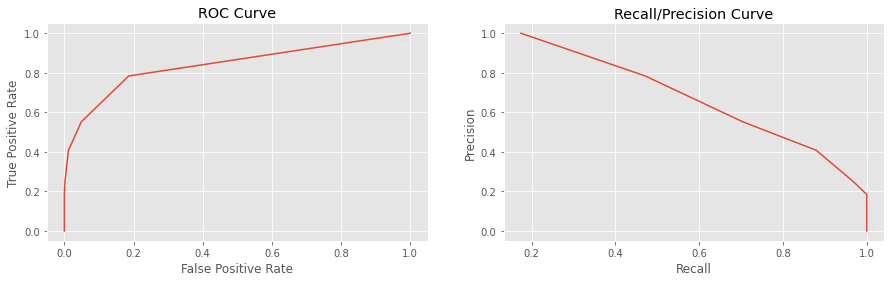

In [29]:
model = KNeighborsClassifier()

plt.figure(figsize=(15, 4))
aio.modelcurve(X, y, model)

In [30]:
dfModel1 = dfModel.copy()

dfModel1 = dfModel1.drop(['knn_p1'])

dfModel1.to_csv('dfModel1_knn.csv',index=True)

## Sonuç

- Hızlı sonuç alabilek için scale edilmiş data kullanıldı.
- Scale edilen veri için performans sonuçları oldukça düşük çıktı. Hız olarak değerlendirilirse, oldulça hızlı sonuç alınabilmektedir.
- Forest'a göre daha düşük performans gösterdi, ama birkaç parametrik değişiklik yapılınca daha düşük değerler alındı.
- Maliyet odaklı incelenirse en kötüler arasında yer aldı.
- Parametrik değişiklikler yapıldıktan sonra daha kötü sonuçlar alındı, default değerler daha iyi sonuçlandı.
    - weights=uniform, nneighbors=5, metric=minkowski